In [1]:
import os
import sys
import json
import numpy as np
import pickle
sys.path.append('/n/data3_vast/hms/neurobio/htem2/users/kd193/spinal_cord_embedding/classification')
from utils import *
from models import MLP
import yaml
from sklearn.metrics import f1_score
import torch
import torch.nn.functional as F

In [2]:
TRAIN_TEST_SPLIT_FILE_PATH = '../classification/datasets/train_test_split_neurons.json'
# TRAIN_EMBED_FILE_PATH = '../classification/datasets/training_embeds_1050_313_useallsyn_05222025.pkl'
# TEST_EMBED_FILE_PATH = '../classification/datasets/testing_embeds_1050_313_useallsyn_0522202.pkl'
TRAIN_EMBED_FILE_PATH = '../classification/datasets/training_embeds_1050_313_useallsyn.pkl'
TEST_EMBED_FILE_PATH = '../classification/datasets/testing_embeds_1050_313_useallsyn.pkl'
EMBEDDING_DIR = '../dataset/embeddings_unnorm' 

MODELS2USE = ['microns', 'h01', 'sp']
AGGREGATE_RADIUS_UM = 10

LABEL_MAP = {
    # 'cltmr': 0 , 
    # 'cltmrunlabeled': 0, 
    # 'abltmr': 1, 
    # 'adltmr': 2,
    # 'chtmrnp': 3, 
    # 'othersn': 4,
    # 'adhtmrp': 5,
    # 'chtmrp': 5,
    # 'cold': 6,

    'adhtmrp': 0,
    'chtmrp': 1,
}

In [4]:
print("- Using previous dataset ...")
with open(TRAIN_TEST_SPLIT_FILE_PATH, 'r') as f:
    data = json.load(f)
    class_to_root_data = data['class_to_root_data']
    train_neurons = data['train_neurons']
    test_neurons = data['test_neurons']
print(f'- Loaded train_test_split file {TRAIN_TEST_SPLIT_FILE_PATH}')

with open(TRAIN_EMBED_FILE_PATH, 'rb') as f:
    train_data_files = pickle.load(f)
with open(TEST_EMBED_FILE_PATH, 'rb') as f:
    test_data_files = pickle.load(f)
print(f"- Loaded training files {TRAIN_EMBED_FILE_PATH}")
print(f"- Loaded testing files {TEST_EMBED_FILE_PATH}")

print('\n')

train_embed, test_embed, train_files_per_class, test_files_per_class = create_dataset_embeds(train_data_files, test_data_files, 
                                            os.path.dirname(EMBEDDING_DIR), LABEL_MAP,
                                           MODELS2USE, EMBEDDING_DIR, AGGREGATE_RADIUS_UM, use_meshdata=False)
print("\n")

train_data_files_flatten = [file for key in sorted(list(LABEL_MAP.keys())) for file in sorted(train_data_files[key])]
test_data_files_flatten = [file for key in sorted(list(LABEL_MAP.keys())) for file in sorted(test_data_files[key])]
# validate_train_test_split(seg_vol=proofread_seg_spinalcord, client=client, train_data_files=train_data_files_flatten, 
#     test_data_files=test_data_files_flatten)

# Gather all embeddings and create labels
all_train_embeddings, train_labels = setup_embeds_and_labels(train_embed, LABEL_MAP)
all_test_embeddings, test_labels = setup_embeds_and_labels(test_embed, LABEL_MAP)

print("Training shape:")
print("- embedding:", all_train_embeddings.shape)
print("- label:", train_labels.shape)
print("Testing shape:")
print("- embedding:", all_test_embeddings.shape)
print("- label:", test_labels.shape)

- Using previous dataset ...
- Loaded train_test_split file ../classification/datasets/train_test_split_neurons.json
- Loaded training files ../classification/datasets/training_embeds_1050_313_useallsyn.pkl
- Loaded testing files ../classification/datasets/testing_embeds_1050_313_useallsyn.pkl


../dataset ../dataset/embeddings_unnorm {'adhtmrp': 0, 'chtmrp': 1}
Working with embedding models -> ['microns', 'h01', 'sp']


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.28s/it]



Training shape:
- embedding: (160, 192)
- label: (160,)
Testing shape:
- embedding: (57, 192)
- label: (57,)


In [ ]:
# train_mesh_features = all_train_embeddings[:, -12:]
# mesh_mean = train_mesh_features.mean(axis=0)
# mesh_std = train_mesh_features.std(axis=0)
# all_train_embeddings[:, -12:] = (train_mesh_features - mesh_mean) / (mesh_std + 1e-8)

# test_mesh_features = all_test_embeddings[:, -12:]
# all_test_embeddings[:, -12:] = (test_mesh_features - mesh_mean) / (mesh_std + 1e-8)

In [17]:
# Load model
MODEL_PATH = '/n/data3_vast/hms/neurobio/htem2/users/kd193/spinal_cord_embedding/classification/models/mlp_cell_type_classifier_adhtmrp_cheat_microns_h01_sp_10umagg.pth'

# read in model to cuda/cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(input_dim=192, num_classes=2) 
_ = model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
_ = model.eval()

In [18]:
# run test labels on the classifier
input_data = torch.tensor(all_test_embeddings, dtype=torch.float32)
input_data = input_data.to(device)
with torch.no_grad():
    outputs = model(input_data)
class_probabilities = outputs.cpu().detach().numpy()
predicted_classes_test = np.argmax(class_probabilities, axis=1)

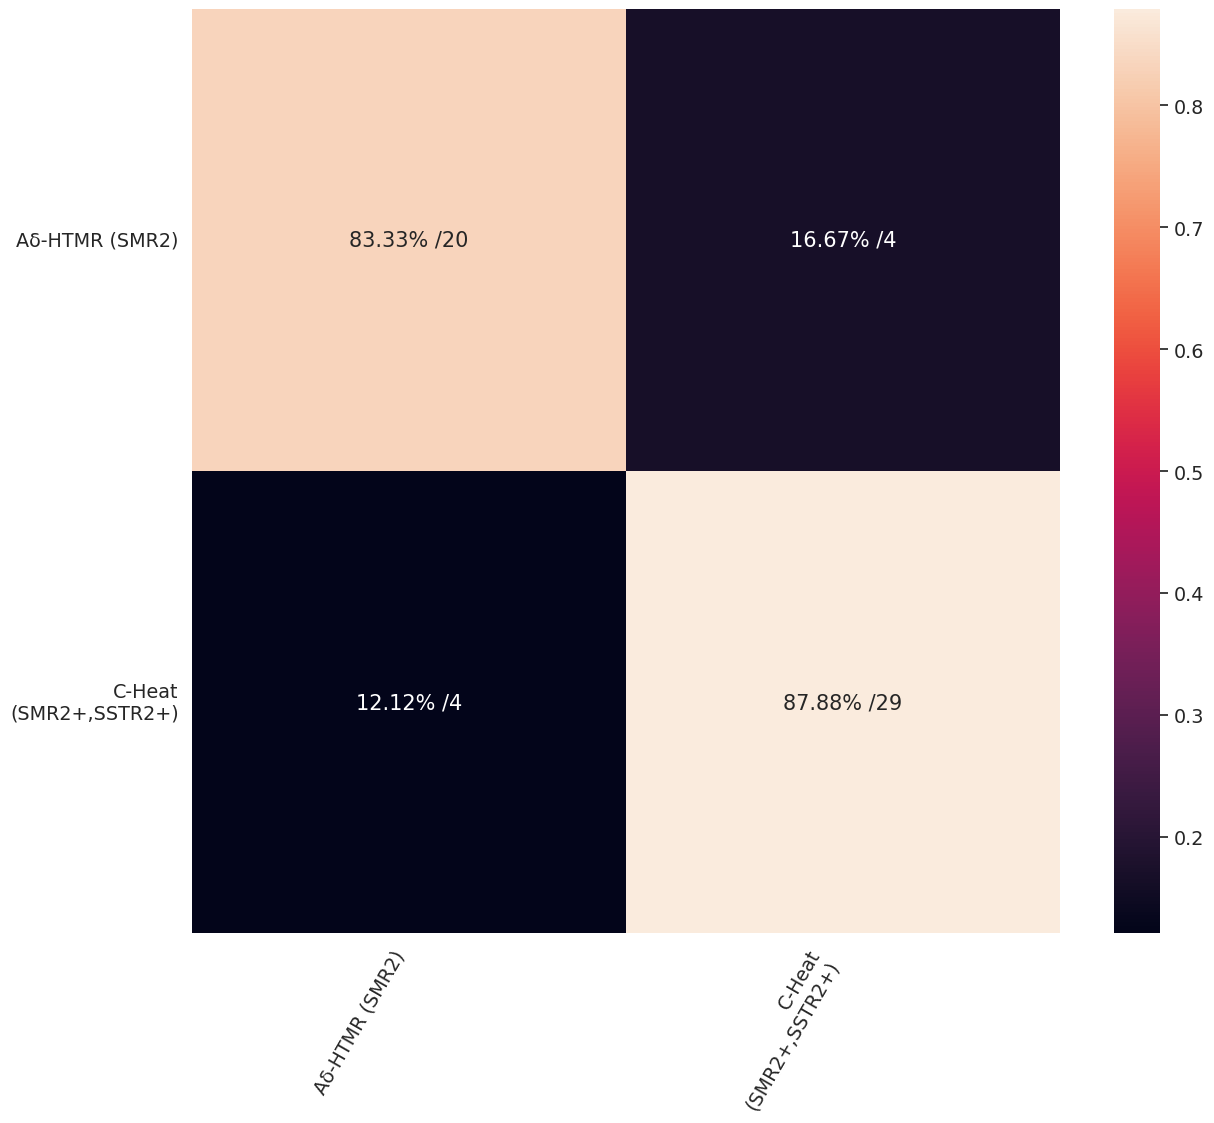

In [19]:
import sklearn.metrics

# classnames = ['C-LTMR','Aβ-LTMR','Aδ-LTMR',
#                'C-HTMR-Non-peptidergic\n(MRGPRD+,\nMRGPRB4+,MRGPRA3+)','C-HTMR\n(SST+)', 'Aδ-HTMR & C-Heat\n(SMR2+,SSTR2+)', 'C-Cold (TRPM8)', ] #'(Non Sensory)\nDendritic Synapses','(Non Sensory)\nAxonal Synapses']

classnames = ['Aδ-HTMR (SMR2)',  'C-Heat\n(SMR2+,SSTR2+)']

# classnames = ['(Sensory)\nLTMRs & HTMRs etc.','(Non Sensory)']

confmat_norm = sklearn.metrics.confusion_matrix(test_labels, predicted_classes_test, normalize='true')
confmat = sklearn.metrics.confusion_matrix(test_labels, predicted_classes_test,)

conf_labeled = []
for i in range(confmat.shape[0]):
    conf_row = []
    for j in range(confmat.shape[1]):
        conf_row.append(f"{round(confmat_norm[i,j]*100,2)}% /{confmat[i,j]}")
    conf_labeled.append(conf_row)
conf_labeled = np.array(conf_labeled)

plt.figure(figsize=(14,12))
sns.set(font_scale=1.25)
sns.heatmap(confmat_norm, annot=conf_labeled, fmt='', xticklabels=classnames,yticklabels=classnames,)
_=plt.xticks(rotation=60, ha='right')
_=plt.yticks(rotation=0, ha='right')

In [21]:
#######################################################################################################################
#######################################################################################################################
#######################################################################################################################
#######################################################################################################################
#######################################################################################################################
#######################################################################################################################
#######################################################################################################################
#######################################################################################################################
#######################################################################################################################

In [96]:
label_map = {
             'abltmr_ret': 1,
             #'adltmr_trkb': 2,
             'chtmrnp_mrgd': 3,
             'chtmrp_sstr2': 5,
             'cold_trpm8': 6,

            }

val_data_files = {'abltmr_ret': glob.glob(os.path.join(embed_dir, 'abltmr_ret/data/*.json')),
                  #'adltmr_trkb': glob.glob(os.path.join(embed_dir, 'adltmr_trkb/data/*.json')),
                  'chtmrp_sstr2': glob.glob(os.path.join(embed_dir, 'chtmrp_sstr2/data/*.json')),
                  'cold_trpm8': glob.glob(os.path.join(embed_dir, 'cold_trpm8/data/*.json')),
                  'chtmrnp_mrgd': glob.glob(os.path.join(embed_dir, 'chtmrnp_mrgd/data/*.json')),        
                }

AGGREGATE_RADIUS_UM = 10
CLASS_DIR = '/n/data3_vast/hms/neurobio/htem2/users/kd193/spinal_cord_embedding/dataset/embeddings_unnorm'
parent_dir = os.path.dirname(embed_dir)
models2use=['microns','h01', 'sp']

In [97]:
print("Collecting embeddings ...")
val_embeds = {}
use_meshdata = False

print(f"Working with embedding models -> {models2use}")
for class_n in label_map.keys():
    
    assert class_n in val_data_files

    # get all embedding files from specific model and class
    all_class_pkl_files_dict = {}
    for model_in_use in models2use:
        all_class_pkl_files = glob.glob(os.path.join(CLASS_DIR, class_n, "embeddings_" + model_in_use, "*.pkl"))
        all_class_data = [] # collect all files from specific class
        for pkl_file in all_class_pkl_files:
            pkl_file = os.path.join(parent_dir, pkl_file)
            assert model_in_use in pkl_file
            assert class_n in pkl_file
            with open(pkl_file, 'rb') as file:
                data = pickle.load(file)
            all_class_data.append(data)
        assert len(all_class_data) > 1 # check to make sure files were correctly collected
        all_class_pkl_files_dict[model_in_use] = all_class_data

    val_subset_data_files = val_data_files[class_n]

    embeds = []
    for json_file in val_subset_data_files:
        json_file = os.path.join(parent_dir, json_file)
        data_embedding = []
        with open(json_file, 'r') as file:
            center_pt_data = json.load(file)
        for model_in_use in models2use:
            assert class_n in json_file
            aggregated_embedding = agg_embedding_v2(center_pt_data, all_class_pkl_files_dict[model_in_use], AGGREGATE_RADIUS_UM)
            data_embedding.append(aggregated_embedding)

        assert len(data_embedding) == len(models2use)

        if use_meshdata:
                mesh_file_path = os.path.join(os.path.dirname(os.path.dirname(json_file)), "meshdata", os.path.basename(json_file).replace(".json", ".pkl"))
                with open(mesh_file_path, 'rb') as f:
                    mesh_data = pickle.load(f)
                mesh_data = np.array([mesh_data[[0,1,2,9,10,11,12,13,14,15,16,17]]])
                data_embedding.append(mesh_data)
            
        data_embedding = np.concatenate(data_embedding, axis=1) # concat embeddings
        embeds.append(data_embedding)    

    val_embeds[class_n] = np.concatenate(embeds, axis=0)

Working with embedding models -> ['microns', 'h01', 'sp']


In [98]:
all_val_embeddings, val_labels = setup_embeds_and_labels(val_embeds, label_map)

In [107]:
input_data = torch.tensor(all_val_embeddings, dtype=torch.float32)
input_data = input_data.to(device)
with torch.no_grad():
    outputs = model(input_data)
class_probabilities = outputs.cpu().detach().numpy()
predicted_classes_val = np.argmax(class_probabilities, axis=1)

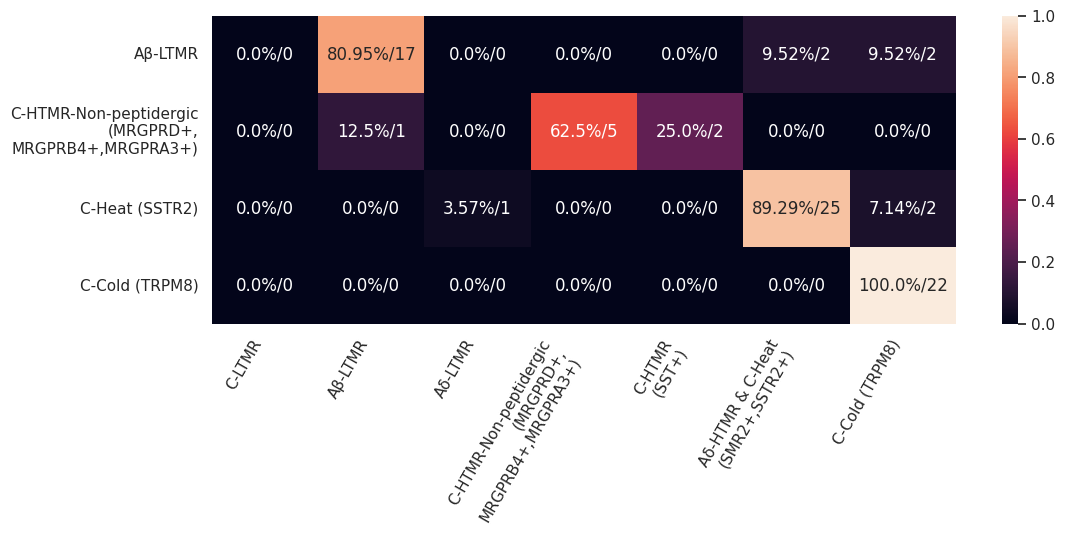

In [109]:
import sklearn.metrics

classnamesx = ['Aβ-LTMR', 'C-HTMR-Non-peptidergic\n(MRGPRD+,\nMRGPRB4+,MRGPRA3+)', 'C-Heat (SSTR2)', 'C-Cold (TRPM8)']
classnames = ['C-LTMR','Aβ-LTMR','Aδ-LTMR', 'C-HTMR-Non-peptidergic\n(MRGPRD+,\nMRGPRB4+,MRGPRA3+)',
                  'C-HTMR\n(SST+)','Aδ-HTMR & C-Heat\n(SMR2+,SSTR2+)', 'C-Cold (TRPM8)', ] #'(Non Sensory)\nDendritic Synapses','(Non Sensory)\nAxonal Synapses']

confmat_norm = sklearn.metrics.confusion_matrix(val_labels, predicted_classes_val, normalize='true',labels=list(range(len(classnames))))
confmat = sklearn.metrics.confusion_matrix(val_labels, predicted_classes_val, labels=list(range(len(classnames))))

conf_labeled = []
for i in range(confmat.shape[0]):
    conf_row = []
    for j in range(confmat.shape[1]):
        conf_row.append(f"{round(confmat_norm[i,j]*100,2)}%/{confmat[i,j]}")
    conf_labeled.append(conf_row)
conf_labeled = np.array(conf_labeled)

conf_labeled = np.delete(conf_labeled, [0,2,4], axis=0)
confmat_norm = np.delete(confmat_norm, [0,2,4], axis=0)

plt.figure(figsize=(12,4))
plt.style.use("dark_background")

sns.set(font_scale=1.0)
sns.heatmap(confmat_norm, annot=conf_labeled, fmt='', xticklabels=classnames,yticklabels=classnamesx, )
_=plt.xticks(rotation=60, ha='right')
_=plt.yticks(rotation=0, ha='right')
#plt.ylabel('Genetically tagged neurons\nfrom smaller EM datasets', rotation=0)

In [5]:
from tqdm import tqdm
import pandas as pd
import torch.nn.functional as F

In [6]:
# Run inference. No ground-truth
AGGREGATE_RADIUS_UM = 10
CLASS_DIR = '/n/data3_vast/hms/neurobio/htem2/users/kd193/spinal_cord_embedding/dataset/embeddings_inf2'
parent_dir = os.path.dirname(embed_dir)
models2use=['microns','h01' ,'sp']

inf_data_files = {'none':  glob.glob(os.path.join(CLASS_DIR, "inference", "data", "*.json"))}

In [7]:
# get all embedding files from specific model and class
all_class_pkl_files_dict = {}
for model_in_use in models2use:
    all_class_pkl_files = glob.glob(os.path.join(CLASS_DIR, "inference", "embeddings_" + model_in_use, "*.pkl"))
    all_class_data = [] # collect all files from specific class
    for pkl_file in all_class_pkl_files:
        pkl_file = os.path.join(parent_dir, pkl_file)
        assert model_in_use in pkl_file
        with open(pkl_file, 'rb') as file:
            data = pickle.load(file)
        #if str(data['root_id']) == root_id:
        all_class_data.append(data)
    assert len(all_class_data) > 1 # check to make sure files were correctly collected
    all_class_pkl_files_dict[model_in_use] = all_class_data

In [8]:
print("Collecting inference embeddings ...")
use_meshdata = False
inf_embeds = []

print(f"Working with embedding models -> {models2use}")

usable_data_files = []

for data_file in tqdm(inf_data_files['none']):

    with open(data_file, 'r') as file:
        center_pt_data = json.load(file)

    root_id = str(center_pt_data["root_id"])

    data_embedding = []
    
    for model_in_use in models2use:
        aggregated_embedding = agg_embedding_v2(center_pt_data, all_class_pkl_files_dict[model_in_use], AGGREGATE_RADIUS_UM)
        data_embedding.append(aggregated_embedding)

    assert len(data_embedding) == len(models2use)

    if use_meshdata:
        mesh_file_path = os.path.join(os.path.dirname(os.path.dirname(data_file)), "meshdata", os.path.basename(data_file).replace(".json", ".pkl"))
        with open(mesh_file_path, 'rb') as f:
            mesh_data = pickle.load(f)

        max_dist = mesh_data[8]/1000
        if max_dist < 0:
            continue
            
        mesh_data = np.array([mesh_data[[0,1,2,9,10,11,12,13,14,15,16,17]]])
        data_embedding.append(mesh_data)
        
    data_embedding = np.concatenate(data_embedding, axis=1) # concat embeddings
    inf_embeds.append(data_embedding)   
    usable_data_files.append(data_file)

inf_embeds = np.concatenate(inf_embeds, axis=0)

Working with embedding models -> ['microns', 'h01', 'sp']


100%|██████████| 828/828 [00:04<00:00, 171.85it/s]


In [9]:
# # normalize meshes by training dataset
# inf_mesh_features = inf_embeds[:, -12:]
# inf_embeds[:, -12:] = (inf_mesh_features - mesh_mean) / (mesh_std + 1e-8)

In [10]:
inf_results = []
batch_size = 100

# convert to tensor
data_tensor = torch.tensor(inf_embeds, dtype=torch.float32).to(device)

# Run inference in chunks
with torch.no_grad():  # Disable gradient computation for efficiency
    for i in range(0, inf_embeds.shape[0], batch_size):
        batch = data_tensor[i : i + batch_size]  # Extract batch
        output = model(batch)  # Run inference
        probabilities = F.softmax(output, dim=1)  # Apply softmax along class dimension
        inf_results.append(probabilities.cpu().numpy())

inf_final_results = np.concatenate(inf_results, axis=0)

In [11]:
#column_names = ['root_id', 'c_x', 'c_y', 'c_z',  'predicted']
expected_label_names = ['cltmr','abltmr','adltmr','chtmrnp','cysltr2/sst','htmrp', 'cold', ] #'(non) dend','(non) axon',]
ood_threshold = 0.5

test_label_map = {'cltmr': 'cltmr', 'u': 'cltmr', 'adltmr': 'adltmr', 'abltmr': 'abltmr', 'chtmr': 'chtmrnp', 'adhtmr': 'htmrp'}

inf_out_dict = []
gt_labels = []
for di, data_file in enumerate(usable_data_files):
    with open(data_file, 'r') as file:
        center_pt_data = json.load(file)

    i_dict = {
        'root_id': center_pt_data['root_id'],
        'c_x': center_pt_data['initial_pt'][0],
        'c_y': center_pt_data['initial_pt'][1],
        'c_z': center_pt_data['initial_pt'][2],
        #'gt': test_label_map[center_pt_data['ground_truth_label']],
    }

    for pi, class_n in enumerate(expected_label_names):
        i_dict[class_n] = round(inf_final_results[di,pi],4)

    if np.max(inf_final_results[di]) < ood_threshold:
        i_dict['predicted'] = 'ood'      
    else:
        i_dict['predicted'] = expected_label_names[np.argmax(inf_final_results[di])]
        
    inf_out_dict.append(i_dict)
inf_df = pd.DataFrame(inf_out_dict)

In [12]:
for class_n in inf_df['predicted'].unique():
    print(class_n, len(inf_df[inf_df['predicted']==class_n]))

htmrp 136
cold 399
cysltr2/sst 107
abltmr 86
chtmrnp 36
ood 31
adltmr 12
cltmr 21


In [52]:
# count_df = inf_df['predicted'].value_counts().reset_index()
# count_df.columns = ['predicted', 'count']

#### pn tacr1
``` 
(non) axon 413
(non) dend 14
htmrp 227
cysltr2/sst 6
ood 6
cold 25
chtmrnp 2
cltmr 3
abltmr 1
```


#### gpr83
```
(non) axon 606
ood 35
(non) dend 56
cold 96
cltmr 11
chtmrnp 4
htmrp 16
abltmr 4
```

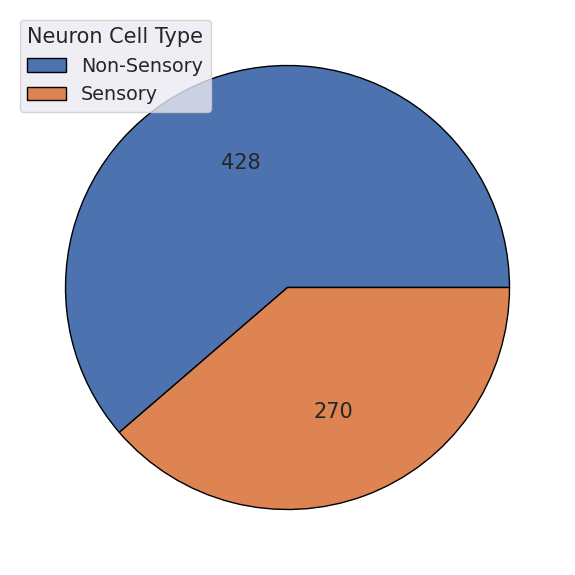

In [160]:
# only looking at sensory neuron synapses
data = [414+14, 227+6+6+25+2+3+1]
labels = ['Non-Sensory', 'Sensory']

fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, _ = ax.pie(data, wedgeprops=dict(edgecolor='black'), autopct=lambda x: '{:.0f}'.format(x/100*sum(data)))
ax.legend(wedges, labels, title="Neuron Cell Type", loc="upper left", ) #bbox_to_anchor=(1, 0.5))
plt.tight_layout()

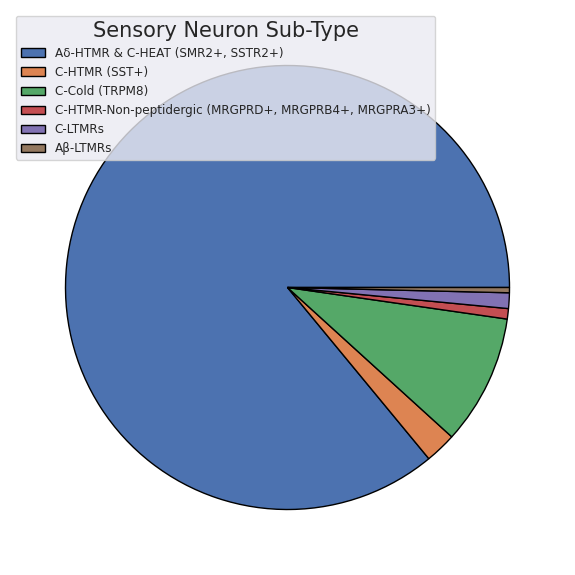

In [153]:
# only looking at sensory neuron synapses
data = [227,6,25,2,3,1]
labels = ['Aδ-HTMR & C-HEAT (SMR2+, SSTR2+)', 'C-HTMR (SST+)', 'C-Cold (TRPM8)', 'C-HTMR-Non-peptidergic (MRGPRD+, MRGPRB4+, MRGPRA3+)', 
          'C-LTMRs', 'Aβ-LTMRs']

fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts = ax.pie(data, wedgeprops=dict(edgecolor='black'))
ax.legend(wedges, labels, title="Sensory Neuron Sub-Type", loc="upper left", fontsize='xx-small') #bbox_to_anchor=(1, 0.5))
plt.tight_layout()

```
(non) axon 606
ood 35
(non) dend 56
cold 96
cltmr 11
chtmrnp 4
htmrp 16
abltmr 4
```

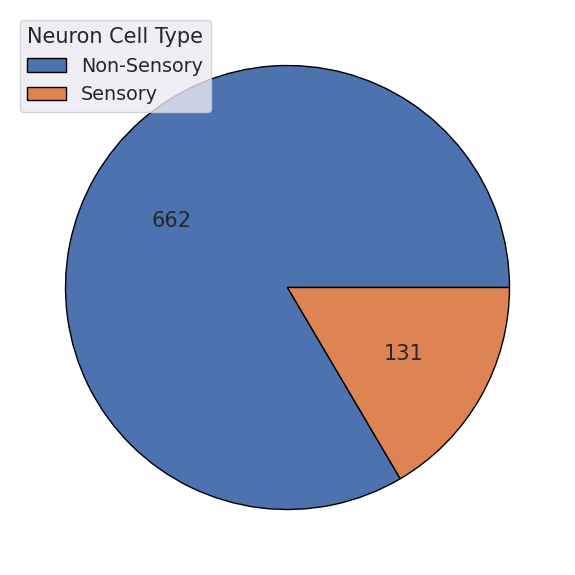

In [159]:
# only looking at sensory neuron synapses
data = [606+56, 96+11+4+16+4]
labels = ['Non-Sensory', 'Sensory']

fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, _ = ax.pie(data, wedgeprops=dict(edgecolor='black'), autopct=lambda x: '{:.0f}'.format(x/100*sum(data)))
ax.legend(wedges, labels, title="Neuron Cell Type", loc="upper left", ) #bbox_to_anchor=(1, 0.5))
plt.tight_layout()

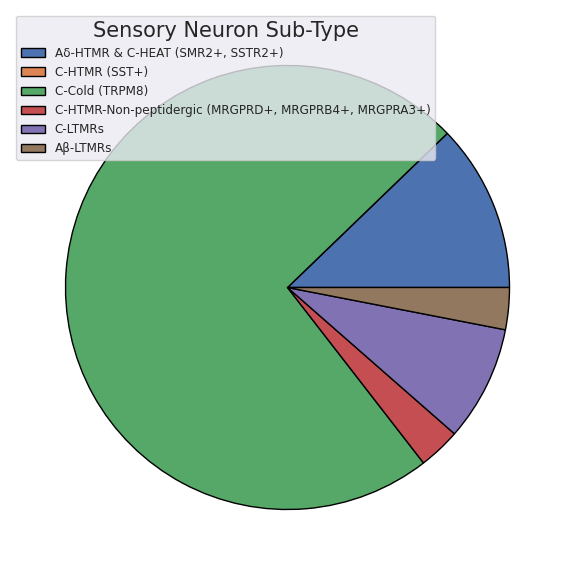

In [156]:
# # only looking at sensory neuron synapses
# data = [96,11,4,16,4]
# labels = ['C-Cold (TRPM8)', 'C-LTMRs', 'C-HTMR-Non-peptidergic (MRGPRD+, MRGPRB4+, MRGPRA3+)', 'Aδ-HTMR & C-HEAT (SMR2+, SSTR2+)', 'Aβ-LTMRs']

data = [16,0, 96,4,11,4]
labels = ['Aδ-HTMR & C-HEAT (SMR2+, SSTR2+)', 'C-HTMR (SST+)', 'C-Cold (TRPM8)', 'C-HTMR-Non-peptidergic (MRGPRD+, MRGPRB4+, MRGPRA3+)', 
          'C-LTMRs', 'Aβ-LTMRs']



fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts = ax.pie(data, wedgeprops=dict(edgecolor='black'), 
)
ax.legend(wedges, labels, title="Sensory Neuron Sub-Type", loc="upper left",  fontsize='xx-small') #bbox_to_anchor=(1, 0.5))
plt.tight_layout()

In [49]:
ng_list = []
for i, row in inf_df[inf_df['predicted'] == 'abltmr'].iterrows():
    ng_list.append([[row['c_x'], row['c_y'], row['c_z']], f"{row['predicted']}"])

In [50]:
def create_json_mini_annot(pos_list, mip=(4,4,45)):
    """ ex: 
            {
          "point": [
            98511.765625,
            15709.01953125,
            1554.680908203125
          ],
          "type": "point",
          "id": "b777ca66c193654817d183cf3ac36e0538678d54" #psuedo ID (add idx to create "new" id)
        }
    """
    final = []
    for idx, [nm_pos, desc] in enumerate(pos_list):
        vert = nm_pos
        em_centroid_voxel = np.array([vert[0]//mip[0], vert[1]//mip[1], vert[2]//mip[2]]) 
        annot_dict = {
            "type": "point",
            "id": "b777ca66c193654817d183cf3ac36e0538678d54" + str(idx),
            "point": [
                em_centroid_voxel[0],
                em_centroid_voxel[1],
                em_centroid_voxel[2],
            ],
            "description": desc
        }
        final.append(annot_dict)
    print(json.dumps(final))

In [51]:
create_json_mini_annot(ng_list, mip=(1,1,1))

[{"type": "point", "id": "b777ca66c193654817d183cf3ac36e0538678d540", "point": [21173.0, 2825.0, 1934.0], "description": "abltmr"}]


In [232]:
count_df['count'].to_list()

[413, 227, 25, 14, 6, 6, 3, 2, 1]

In [237]:
# grouping non sensory neurons together
data = [596, 253, 34, 8, 7, 4, 3, 2]
labels = ['Non Sensory Neuron', 'HTMR (peptidergic)', 'Out-of-Distribution', 'COLD', 'cysltr2/sst', 'C-LTMR', 'Ab-LTMR', 'C-HTMR (non-peptidergic)']

# only looking at sensory neuron synapses
data = [227, 14, 6, 6, 3, 2, 1]
labels = ['HTMR (peptidergic)', 'COLD', 'Cysltr2/sst', 'C-LTMR', 'Ab-LTMR', 'C-HMTR (non-peptidergic)']


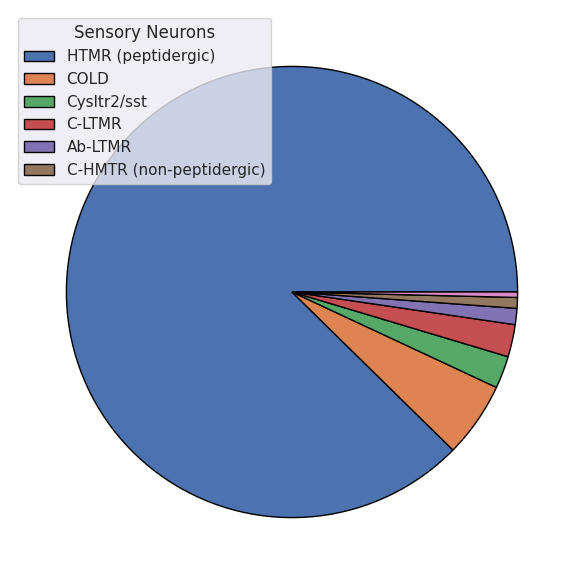

In [238]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Create pie chart without labels inside
wedges, texts = ax.pie(data, wedgeprops=dict(edgecolor='black'))

# Place labels on the side
ax.legend(wedges, labels, title="Sensory Neurons", loc="upper left", ) #bbox_to_anchor=(1, 0.5))

# Show the plot
plt.tight_layout()

In [34]:
# with open('/n/data3_vast/hms/neurobio/htem2/users/kd193/spinal_cord_embedding/dataset/annots_processed/21132_6350_1717_rootid_2_coords.json', 'r') as f:
#     rootids_2_coord = json.load(f)

# for key in rootids_2_coord.keys():
#     coords = rootids_2_coord[key]['coords']
#     data_dir =  '/n/data3_vast/hms/neurobio/htem2/users/kd193/spinal_cord_embedding/dataset/embeddings_24104_3598_1701/inference/data'
#     for coord in coords:
#         data_file = os.path.join(data_dir, f'{key}_{str(int(coord[0])*32)}_{str(int(coord[1])*32)}_{str(int(coord[2])*45)}_data.json')
#         if os.path.exists(data_file):
#             with open(data_file, 'r') as f:
#                 data = json.load(f)
#             data['synapse_id'] = new_dict[tuple(coord)]
#             with open(data_file, 'w') as f:
#                 json.dump(data, f)

In [2]:
import os
import glob
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Load up MLP
cell_type_model_path = '/n/data3_vast/hms/neurobio/htem2/users/kd193/spinal_cord_embedding/classification/models/mlp_cell_type_classifier__microns_h01_sp_10umagg.pth'
sensory_non_sensory_model_path = '/n/data3_vast/hms/neurobio/htem2/users/kd193/spinal_cord_embedding/classification/models/mlp_sen_nonsen_classifier_99acc_micronsh01_noagg.pth'
# cell_type_model_path = '/n/data3_vast/hms/neurobio/htem2/users/kd193/spinal_cord_embedding/classification/models/mlp_cell_type_classifier_v2.pth'
# sensory_non_sensory_model_path = '/n/data3_vast/hms/neurobio/htem2/users/kd193/spinal_cord_embedding/classification/models/mlp_sensory_vs_non_sensory_classifier_v2.pth'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Read in sensory vs non sensory classifier
sensory_non_sensory_classifier_model = MLP(input_dim=128, num_classes=2) 
_ = sensory_non_sensory_classifier_model.load_state_dict(torch.load(sensory_non_sensory_model_path, map_location=device))
sensory_non_sensory_classifier_model = sensory_non_sensory_classifier_model.to(device)
_ = sensory_non_sensory_classifier_model.eval()

# Read in cell type classifier
cell_type_classifier_model = MLP(input_dim=192, num_classes=7) 
_ = cell_type_classifier_model.load_state_dict(torch.load(cell_type_model_path, map_location=device))
cell_type_classifier_model = cell_type_classifier_model.to(device)
_ = cell_type_classifier_model.eval()

In [173]:
embedding_dir = '/n/data3_vast/hms/neurobio/htem2/users/kd193/spinal_cord_embedding/dataset/embeddings_44611_6738_1017/inference'
MODELS2USe = ['microns', 'h01', 'sp']
AGG_RADIUS = 10

In [174]:
all_synapses_data_files = sorted(glob.glob(os.path.join(embedding_dir, 'data', '*.json'))) # Get all JSON files
all_synapses_data_files_valid = []
all_embeddings, synapse_ids, synapse_coords = [], [], []
syn_count = 0

for syn_data_file in tqdm(all_synapses_data_files, desc='Collecting embeddings'):
    with open(syn_data_file, 'r') as file:
        synapse_meta_data = json.load(file)

    root_id = synapse_meta_data["root_id"]
    coords_2_embed = synapse_meta_data["nm_coords"]
    initial_pt = synapse_meta_data["initial_pt"] # in 32nm
    initial_pt_in_nm = synapse_meta_data["initial_pt_in_nm"]

    if 'synapse_id' in synapse_meta_data:
        synapse_id = int(synapse_meta_data['synapse_id'])
    else:
        synapse_id = syn_count
        syn_count += 1
        
    # Filter coordinates to only collect embeddings within ina AGG_RADIUS
    filtered_coords_2_embed = []
    for center_pt_nm in coords_2_embed:
        euc_dist = np.linalg.norm(initial_pt_in_nm - np.array(center_pt_nm))
        if euc_dist <= AGG_RADIUS *1000:
            filtered_coords_2_embed.append(center_pt_nm)

    # Convert coordinates to .pkl files
    nm_coords_tuple = [(coord[0], coord[1], coord[2]) for coord in filtered_coords_2_embed]
    nm_coords_file_paths = [f"{str(int(coord[0]))}_{str(int(coord[1]))}_{str(int(coord[2]))}.pkl" for coord in filtered_coords_2_embed]

    # Concatenate embeddings here (MICrONs, H01, Own SpinalCord)
    concatenated_embeddings = []

    leave = False
    # Loop through each embedding model
    for model in MODELS2USe:
        # Append to this and aggregate embeddings (take mean)
        aggregate_embeddings = []

        embedding_info_path = os.path.join(embedding_dir, 'embeddings_' + model, f'{root_id}_embeddings.pkl')
        with open(embedding_info_path, 'rb') as file:
            embedding_info = pickle.load(file)
        for nm_coord_key in nm_coords_tuple: # Through each coordinate
            embedding = embedding_info['nm_center_pts_2_embeddings'][nm_coord_key]
            try:
                aggregate_embeddings.append(embedding[np.newaxis,:])
            except Exception as e:
                leave = True
                break # leave loop if embedding isnt done
        if leave:
            break

        # for nm_coord_file_path in nm_coords_file_paths:
        #     nm_coord_file_path  = os.path.join(embedding_dir, 'embeddings_' + model, nm_coord_file_path)
        #     with open(nm_coord_file_path, 'rb') as file:
        #         embedding_info = pickle.load(file)
        #     try:
        #         embedding = embedding_info['embedding']
        #         aggregate_embeddings.append(embedding)
        #     except Exception as e:
        #         leave = True
        #         break # leave loop if embedding isnt done
        # if leave:
        #     break
            
        aggregate_embeddings = np.concatenate(aggregate_embeddings, axis=0)
        aggregate_embeddings = np.array([np.mean(aggregate_embeddings, axis=0)])
        concatenated_embeddings.append(aggregate_embeddings)
                
    if leave:
        continue

    concatenated_embeddings = np.concatenate(concatenated_embeddings, axis=1)
    all_synapses_data_files_valid.append(syn_data_file)
    all_embeddings.append(concatenated_embeddings)
    synapse_ids.append(synapse_id)
    synapse_coords.append(initial_pt)

all_embeddings = np.concatenate(all_embeddings, axis=0)
synapse_ids = np.array(synapse_ids)
synapse_coords = np.array(synapse_coords)
print('All embeddings:', all_embeddings.shape)
     

All embeddings: (1761, 192)


In [175]:
# with open('/n/data3_vast/hms/neurobio/htem2/users/kd193/spinal_cord_embedding/dataset/embeddings_21132_6350_1717/inference/embeddings_h01/608173_187368_75605.pkl', 'rb') as file:
#     test_embedding_info = pickle.load(file)
# test_embedding_info

In [176]:
# with open('/n/data3_vast/hms/neurobio/htem2/users/kd193/spinal_cord_embedding/dataset/embeddings_21132_6350_1717/inference/embeddings_h01/76210312822485624_embeddings.pkl', 'rb') as file:
#     test_embedding_info = pickle.load(file)
# test_embedding_info

In [177]:
# Labels
sensory_non_sensory_label_map = {0: True, 1: False,}
cell_type_label_map = {-1: 'N/A', 0: 'C-LTMR', 1: 'Aβ-LTMR', 2: 'Aδ-LTMR', 3: 'C-HTMR-Non-peptidergic', 
             4: 'C-HTMR',5: 'Aδ-HTMR & C-Heat', 6: 'C-Cold'}

print('Running sensory vs. non-sensory neuron classifier ...')
# Convert embeddings to tensor and run
input_data = torch.tensor(all_embeddings[:,:128], dtype=torch.float32)
input_data = input_data.to(device)

# Predict synapse as sensory vs non-sensory
with torch.no_grad():
    outputs = sensory_non_sensory_classifier_model(input_data)
outputs = F.softmax(outputs, dim=1)
sensory_non_sensory_class_probabilities = outputs.cpu().detach().numpy()
sensory_non_sensory_class_probabilities = np.round(sensory_non_sensory_class_probabilities, decimals=4) 
predicted_sensory_non_sensory_classes = np.argmax(sensory_non_sensory_class_probabilities, axis=1)

# Only keep synapses that are classified as sensory
filter_sensory_neurons_only_mask = predicted_sensory_non_sensory_classes == 0
all_embeddings_sensory = all_embeddings[filter_sensory_neurons_only_mask, :]
print(f'{len(all_embeddings_sensory)}/{len(all_embeddings)} synapses predicted as sensory!')

print('Predicting cell type ...')
# Predict synapse cell type
input_data = torch.tensor(all_embeddings_sensory, dtype=torch.float32)
input_data = input_data.to(device)
with torch.no_grad():
    outputs = cell_type_classifier_model(input_data)
outputs = F.softmax(outputs, dim=1)
cell_type_class_probabilities = outputs.cpu().detach().numpy()
cell_type_class_probabilities = np.round(cell_type_class_probabilities, decimals=4) 
cell_type_class_probabilities_main = np.ones((sensory_non_sensory_class_probabilities.shape[0], 7)) * -1
cell_type_class_probabilities_main[filter_sensory_neurons_only_mask, :] = cell_type_class_probabilities
predicted_cell_type_classes = np.argmax(cell_type_class_probabilities, axis=1)

predicted_cell_type_classes_main = np.ones((sensory_non_sensory_class_probabilities.shape[0],)) * -1
predicted_cell_type_classes_main[filter_sensory_neurons_only_mask] = predicted_cell_type_classes

predicted_sensory_non_sensory_classes_label = [sensory_non_sensory_label_map[pred_label] for pred_label in predicted_sensory_non_sensory_classes]
predicted_cell_type_classes_label = [cell_type_label_map[pred_label] for pred_label in predicted_cell_type_classes_main]

print('Done!')

Running sensory vs. non-sensory neuron classifier ...
1012/1761 synapses predicted as sensory!
Predicting cell type ...
Done!


In [178]:
cell_type_classifier_data = [
    synapse_ids, synapse_coords,
    sensory_non_sensory_class_probabilities[:,0],
    sensory_non_sensory_class_probabilities[:,1],
    predicted_sensory_non_sensory_classes_label,
    
    cell_type_class_probabilities_main[:,0],
    cell_type_class_probabilities_main[:,1],
    cell_type_class_probabilities_main[:,2],
    cell_type_class_probabilities_main[:,3],
    cell_type_class_probabilities_main[:,4],
    cell_type_class_probabilities_main[:,5],
    cell_type_class_probabilities_main[:,6],  
    predicted_cell_type_classes_label,
    
    ['v2_04292025' for _ in range(len(predicted_cell_type_classes_label))],
    ['v2_04292025' for _ in range(len(predicted_cell_type_classes_label))]
]

synapse_cell_type_pred_df = pd.DataFrame(list(zip(*cell_type_classifier_data)), columns=['id', 'pt_position', 'sensory', 'non-sensory', 'is_sensory',
                                            'cltmr', 'abltmr', 'adltmr', 'chtmrnp', 'c-htmr', 'htmrp', 'cold', 'cell_type', 
                                            'sen_nonsen_model_ver', 'cell_type_model_ver'])

In [179]:
synapse_cell_type_pred_df

,id,pt_position,sensory,non-sensory,is_sensory,cltmr,abltmr,adltmr,chtmrnp,c-htmr,htmrp,cold,cell_type,sen_nonsen_model_ver,cell_type_model_ver
0,12405322,"[9721.0, 4925.0, 2046.0]",0.0007,0.9993,False,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,N/A,v2_04292025,v2_04292025
1,10734193,"[8814.0, 4929.0, 1944.0]",0.9999,0.0001,True,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,Aδ-LTMR,v2_04292025,v2_04292025
2,9141437,"[7813.0, 5386.0, 2046.0]",1.0000,0.0000,True,0.0000,0.0001,0.9999,0.0000,0.0000,0.0000,0.0000,Aδ-LTMR,v2_04292025,v2_04292025
3,9578617,"[8124.0, 5425.0, 2043.0]",1.0000,0.0000,True,0.0001,0.0004,0.9991,0.0000,0.0001,0.0001,0.0001,Aδ-LTMR,v2_04292025,v2_04292025
4,11155604,"[8998.0, 4984.0, 1929.0]",1.0000,0.0000,True,0.0001,0.0001,0.9998,0.0000,0.0000,0.0000,0.0000,Aδ-LTMR,v2_04292025,v2_04292025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1756,91485875,"[49039.0, 6601.0, 1966.0]",0.0124,0.9876,False,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,-1.0000,N/A,v2_04292025,v2_04292025
1757,91485882,"[49054.0, 6579.0, 1979.0]",0.9468,0.0532,True,0.0002,0.0063,0.0081,0.1831,0.0724,0.0008,0.7291,C-Cold,v2_04292025,v2_04292025
1758,91098288,"[48921.0, 7092.0, 433.0]",0.9998,0.0002,True,0.0000,0.0001,0.9750,0.0006,0.0232,0.0000,0.0010,Aδ-LTMR,v2_04292025,v2_04292025
1759,91098136,"[48824.0, 7123.0, 461.0]",0.9994,0.0006,True,0.0016,0.0114,0.9269,0.0021,0.0280,0.0128,0.0172,Aδ-LTMR,v2_04292025,v2_04292025


In [180]:
#synapse_cell_type_pred_df.to_feather('cell_type_predictions_w_gpr83_pn.feather')

In [181]:
#synapse_cell_type_pred_df = pd.read_feather('cell_type_prediction_w_gpr83_pn.feather')
# _ = plt.hist(synapse_cell_type_pred_df_only_sensory['max_probability'], bins=20, edgecolor='black')

In [182]:
CELL_TYPE_MIN_PROB = 0.7
SEN_VS_NONSEN_MIN_PROB = 0.7

sensory_non_sensory_label_map = {0: 'Sensory', 1: 'Non-sensory',}
cell_type_label_map = {-1: 'N/A', 0: 'C-LTMR', 1: 'Aβ-LTMR', 2: 'Aδ-LTMR', 3: 'C-HTMR-Non-peptidergic', 
             4: 'C-HTMR',5: 'Aδ-HTMR & C-Heat', 6: 'C-Cold'}

# Get sensory vs. nonsensory synapse count
sensory_count = len(synapse_cell_type_pred_df[synapse_cell_type_pred_df['is_sensory'] == True])
nonsensory_count = len(synapse_cell_type_pred_df[synapse_cell_type_pred_df['is_sensory'] == False])
predicted_sensory_non_sensory_counts = [sensory_count, nonsensory_count]
predicted_sensory_non_sensory_labels = ['Sensory', 'Non-sensory']

predicted_cell_type_counts, predicted_cell_type_labels = [], []

# Only sensory neurons | Filter only synapses with > prob_thresh
synapse_cell_type_pred_df_only_sensory = synapse_cell_type_pred_df[synapse_cell_type_pred_df['is_sensory'] == True]
synapse_cell_type_pred_df_only_sensory = synapse_cell_type_pred_df_only_sensory[synapse_cell_type_pred_df_only_sensory['sensory'] >= SEN_VS_NONSEN_MIN_PROB]

# Get max probability for each row
synapse_cell_type_pred_df_only_sensory['max_probability'] = synapse_cell_type_pred_df_only_sensory[['cltmr', 'abltmr', 
                                             'adltmr', 'chtmrnp', 'c-htmr', 'htmrp', 'cold']].max(axis=1)

# Filter only synapses with > prob_thresh
synapse_cell_type_pred_df_only_sensory = synapse_cell_type_pred_df_only_sensory[synapse_cell_type_pred_df_only_sensory['max_probability'] >= CELL_TYPE_MIN_PROB]

for cell_type in synapse_cell_type_pred_df_only_sensory['cell_type'].unique():
    predicted_cell_type_counts.append(len(synapse_cell_type_pred_df_only_sensory[synapse_cell_type_pred_df_only_sensory['cell_type']==cell_type]))
    predicted_cell_type_labels.append(cell_type)

# Sort
paired = list(zip(predicted_cell_type_counts, predicted_cell_type_labels))
paired.sort(reverse=True)
predicted_cell_type_counts, predicted_cell_type_labels = zip(*paired)
predicted_cell_type_counts, predicted_cell_type_labels = list(predicted_cell_type_counts), list(predicted_cell_type_labels)


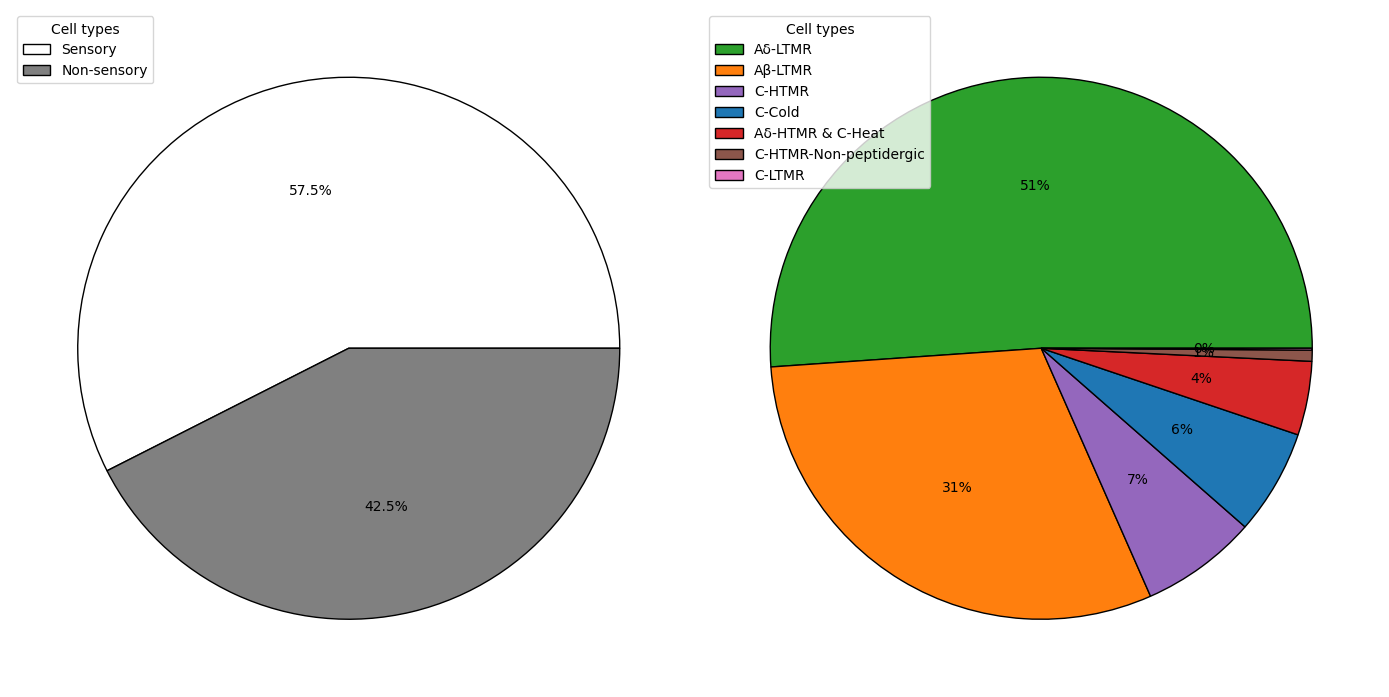

In [183]:
# Create figure and axis
fig, ax = plt.subplots(1, 2, figsize=(14, 10))

sen_nonsen_label_color_map = {
    "Sensory": "white",  
    "Non-sensory": "gray", }

cell_type_label_color_map = {
    "C-Cold": "#1f77b4",  # blue
    "Aβ-LTMR": "#ff7f0e",  # orange
    "Aδ-LTMR": "#2ca02c",  # green
    "Aδ-HTMR & C-Heat": "#d62728",  # red
    "C-HTMR": "#9467bd",  # purple
    "C-HTMR-Non-peptidergic": "#8c564b",  # brown
    "C-LTMR": "#e377c2",  # pink
}

# Generate color lists for each pie chart using the map
colors_sensory = [sen_nonsen_label_color_map[label] for label in predicted_sensory_non_sensory_labels]
colors_cell_types = [cell_type_label_color_map[label] for label in predicted_cell_type_labels]

wedges, texts, autotexts = ax[0].pie(predicted_sensory_non_sensory_counts, wedgeprops=dict(edgecolor='black'), autopct='%1.1f%%', colors=colors_sensory)
ax[0].legend(wedges, predicted_sensory_non_sensory_labels, title="Cell types", loc="upper left")

wedges, texts, autotexts = ax[1].pie(predicted_cell_type_counts, wedgeprops=dict(edgecolor='black'), autopct='%1.0f%%', colors=colors_cell_types)
ax[1].legend(wedges, predicted_cell_type_labels, title="Cell types", loc="upper left")

plt.tight_layout()

### Create mesh features

In [55]:
from meshparty import trimesh_io
import trimesh
import numpy as np
import glob
import json
from tqdm import tqdm
import h5py

In [50]:
embed_dir = "/n/data3_vast/hms/neurobio/htem2/users/kd193/spinal_cord_embedding/dataset/embeddings_test/inference"
data_file_list = glob.glob(os.path.join(embed_dir, "data", "*.json"))

exclude_list = [] #["chtmrp_sstr2", "abltmr_ret", "adltmr_trkb", "cold_trpm8", "mrgd"]

In [52]:
# mm = trimesh_io.MeshMeta(
#     cv_path = "graphene://https://cave.fanc-fly.com/segmentation/table/wclee_mouse_spinalcord_cltmr",
#     disk_cache_path = "spinal_cord_meshes",
#     map_gs_to_https=True)
mesh_dir = "/n/data3_vast/hms/neurobio/htem2/users/kd193/spinal_cord_embedding/embed/spinal_cord_meshes"

In [56]:
def extract_mesh_features(vertices, faces, center, mesh_radius):

    #vertices, faces = mesh.vertices, mesh.faces
    # Compute Euclidean distances from center to all vertices
    distances = np.linalg.norm(vertices - center, axis=1)  # Shape: (N,)
    
    # Filter vertices within 5 μm (5000 nm)
    radius = mesh_radius  # nm
    mask = distances <= radius
    filtered_vertices = vertices[mask]
    
    filtered_vertex_indices = np.where(mask)[0]
    face_mask = np.all(np.isin(faces, filtered_vertex_indices), axis=1)
    filtered_faces = faces[face_mask]
    vertex_index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(filtered_vertex_indices)}
    filtered_faces_remapped = np.array([[vertex_index_map[idx] for idx in face] for face in filtered_faces])
    submesh = trimesh.Trimesh(vertices=filtered_vertices, faces=filtered_faces_remapped)

    # Extract features
    num_vertices = len(filtered_vertices)
    centroid = filtered_vertices.mean(axis=0) if num_vertices > 0 else np.zeros(3)
    extents = (np.max(filtered_vertices, axis=0) - np.min(filtered_vertices, axis=0)) if num_vertices > 0 else np.zeros(3)
    vertex_std = filtered_vertices.std(axis=0) if num_vertices > 0 else np.zeros(3)
    dist_mean = distances[mask].mean() if num_vertices > 0 else 0
    dist_std = distances[mask].std() if num_vertices > 0 else 0
    dist_max = distances[mask].max() if num_vertices > 0 else 0
    surface_area = submesh.area if len(submesh.faces) > 0 else 0
    volume = submesh.volume if len(submesh.faces) > 0 else 0
    cov = np.cov(filtered_vertices.T) if num_vertices > 1 else np.zeros((3, 3))
    eigenvalues = np.sort(np.linalg.eigvals(cov)) if num_vertices > 1 else np.zeros(3)

    mesh_features = np.concatenate([ # use 0,1,2,9,10,11,12,13,14,15,16,17
        [num_vertices, surface_area, volume],  # Scalars (3) 0,1,2
        centroid,                              # 3D (3)  3,4,5
        extents,                               # 3D (3)  6,7,8
        vertex_std,                            # 3D (3)  9,10,11
        [dist_mean, dist_std, dist_max],       # Distance stats (3) 12,13,14
        eigenvalues                            # Shape (3)  15,16,17
    ])

    return mesh_features

In [57]:
# radius (in nm)
mesh_radius = 5000.0

missing_files = []

for data_file in tqdm(data_file_list):

    # skip = False
    # for cn in exclude_list:
    #     if cn in data_file:
    #         skip=True
    #         break
    # if skip:
    #     continue
    
    with open(data_file, 'r') as file:
        data = json.load(file)
    root_id = data['root_id']
    initial_pt_in_nm = data['initial_pt_in_nm']

    class_dir = os.path.dirname(os.path.dirname(data_file))
    class_mesh_dir = os.path.join(class_dir, "meshdata")
    os.makedirs(class_mesh_dir, exist_ok=True)
    save_mesh_data_path = os.path.join(class_mesh_dir, os.path.basename(data_file).replace(".json", ".pkl"))

    if os.path.exists(save_mesh_data_path):
        continue # skip

    mesh_path = os.path.join(mesh_dir, f"{root_id}.h5")
    if os.path.exists(mesh_path) == False:
        missing_files.append([root_id, data_file])
        continue

    with h5py.File(mesh_path, "r") as f:
        vertices = f["vertices"][()]
        faces = f["faces"][()]
    # mesh = mm.mesh(filename=mesh_path)
    mesh_features=extract_mesh_features(vertices, faces, center=initial_pt_in_nm, mesh_radius=mesh_radius)

    # Open the file in binary write mode
    with open(save_mesh_data_path, 'wb') as file:
        # Dump the array to the file
        pickle.dump(mesh_features, file)


100%|██████████| 667/667 [00:47<00:00, 14.07it/s]


In [58]:
with open(save_mesh_data_path, 'rb') as f:
    mesh_data = pickle.load(f)
print(mesh_data)

[1.55500000e+03 1.51274545e+07 8.40050140e+10 6.74214643e+05
 1.48253447e+05 1.05109120e+05 5.76300000e+03 2.19300000e+03
 1.80200000e+03 1.55781864e+03 4.96317976e+02 4.17732036e+02
 1.51012120e+03 1.29256111e+03 4.99767736e+03 8.63640950e+04
 9.48502139e+04 2.66824863e+06]


### Test generating annot for synapse table

In [8]:
import caveclient

In [9]:
# Setup caveclient
client = caveclient.CAVEclient("wclee_mouse_spinalcord_cltmr", ) #server_address='https://global.daf-apis.com')

In [30]:
post_synaptic_neuron_root_id = 720575940881110925 #720575940882124516
save_dir = '/n/data3_vast/hms/neurobio/htem2/users/kd193/spinal_cord_embedding/dataset/dfs'

In [29]:
client.materialize.query_table('synapses_v2', filter_equal_dict = {'id': 13771474})

,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position
0,13771474,2025-03-25 13:39:09.340218+00:00,NaN,t,297,73817844575403683,720575940389570342,73677175739439634,720575940881110925,"[338048, 192848, 103860]","[338416, 193200, 103860]","[337904, 193088, 103905]"


In [31]:
def create_post_synapse_data_from_synapse_table(post_synaptic_neuron_root_id, min_size=5, verbose=True):
    """ Generating post synaptic dataframe and creating annot list of coordinates """

    if verbose:
        print(f'Working with post synaptic neuron: {post_synaptic_neuron_root_id}')

    # Get information from post synaptic neuron
    post_synapse_df = client.materialize.query_table('synapses_v2', filter_equal_dict = {'post_pt_root_id': post_synaptic_neuron_root_id})
    post_synapse_df = post_synapse_df[post_synapse_df['size']>=min_size] # Filter by size
    post_synapse_df = post_synapse_df[post_synapse_df['pre_pt_root_id'] != post_synapse_df['post_pt_root_id']] # Remove synapses onto same neuron
    
    # Get presynapse coordinates from post synapse neuron
    presynapse_nm_coordinates = []
    for i, row in post_synapse_df.iterrows():
        pre_pt_position = np.array(row['pre_pt_position'])
        pre_pt_position[:2] =  pre_pt_position[:2] // 32
        pre_pt_position[2] = pre_pt_position[2] // 45

        presynapse_nm_coordinates.append({
            "synapse_id": row["id"], # synapse id
            "coord": pre_pt_position, # in nm
            "label": None
        })
        
    if verbose:
        print(f'Total number of presynapse coordinates: {len(presynapse_nm_coordinates)}')
        
    return presynapse_nm_coordinates

In [32]:
presynapse_nm_coordinates = create_post_synapse_data_from_synapse_table(post_synaptic_neuron_root_id, min_size=20, verbose=True)

Working with post synaptic neuron: 720575940881110925
Total number of presynapse coordinates: 1987


In [33]:
new_dict = {tuple(d['coord']): d['synapse_id'] for d in presynapse_nm_coordinates}

### Test EM volume and Seg volume

In [54]:
import caveclient
import matplotlib.pyplot as plt
import numpy as np

In [65]:
def create_lut(labels):
    relabels = np.unique(labels)
    new_labels = labels.copy()

    for i, li in enumerate(relabels):
        new_labels[labels==li] = i

    labels = new_labels
    
    max_label = np.max(labels)
    lut = np.random.randint(low=0,high=255,size=(int(max_label + 1), 3),dtype=np.uint8)
    lut = np.append(lut,np.zeros((int(max_label + 1), 1),dtype=np.uint8) + 255,axis=1)
    lut[0] = 0
    colored_labels = lut[labels]
    return colored_labels

In [78]:
EM_PATH = "precomputed://gs://htem_dorsalhorn_mrgd_r1093/dorsal_sections/dorsal_sections_0-500"
SEG_PATH = "graphene://https://cave.fanc-fly.com/segmentation/table/mouse_dorsal_spine"

em_spinalcord = cloudvolume.CloudVolume(EM_PATH, use_https=True, fill_missing=True, mip=(4,4,45), progress=False)
seg_spinalcord = cloudvolume.CloudVolume(SEG_PATH, use_https=True, mip=(32,32,45), agglomerate=True, progress=False)

In [85]:
843693//4, 157981//4, 8789//45

(210923, 39495, 195)

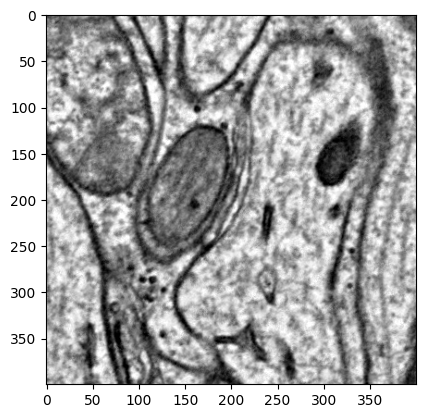

In [86]:
plt.imshow(em_spinalcord[210923-200:210923+200, 39495-200:39495+200, 195][:,:,0,0], cmap='gray')

In [87]:
843693//32, 157981//32, 8789//45

(26365, 4936, 195)

In [90]:
np.unique(seg_spinalcord[26365-20:26365+20, 4936-20:4936+20, 195])

VolumeCutout([720575940418244507, 720575940519918142, 720575940523864849,
              720575940523867665, 720575940526181939, 720575940531058126,
              720575940534035102, 720575940539249474, 720575940544557744,
              720575940546824919, 720575940546858199, 720575940547925460],
             dtype=uint64)

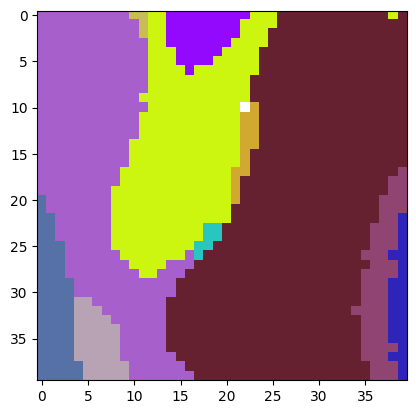

In [89]:
plt.imshow(create_lut(seg_spinalcord[26365-20:26365+20, 4936-20:4936+20, 195][:,:,0,0]))

In [79]:
154260, 37840, 222

(154260, 37840, 222)

In [80]:
154260//4, 37840//4, 222

(38565, 9460, 222)

In [81]:
154260//8, 37840//8, 222

(19282, 4730, 222)

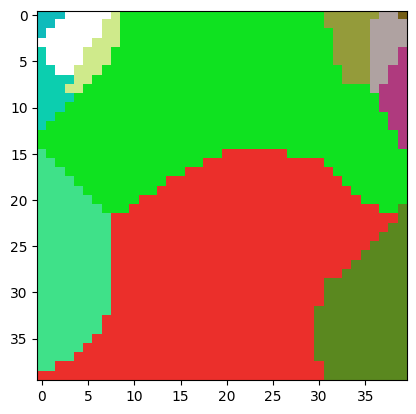

In [82]:
plt.imshow(create_lut(seg_spinalcord[19282-20:19282+20, 4730-20:4730+20, 222][:,:,0,0], ))

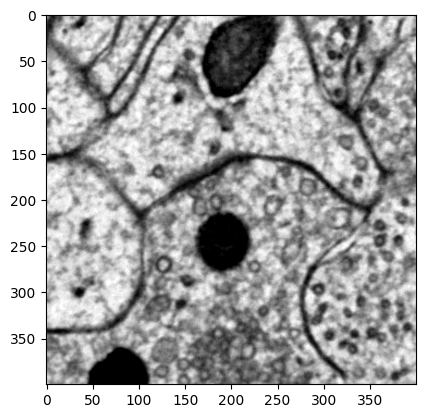

In [83]:
plt.imshow(em_spinalcord[154260-200:154260+200, 37840-200:37840+200, 222][:,:,0,0], cmap='gray')